<h1> Making an predictive model using Decision Tree</h1>
In deze jupyter notebook file, worden de de decision tree gemaakt. 
Dit wordt gedaan om de onderzoeksvraag van mijn thesis te kunnen beantwoorden:
To what extent can support vector machine, randomforest tree, or Gradient Boosting Machine contributeto predicting the demand for the specialist youth caresegments in Amsterdam?
Ook is dit nodig voor het beantwoorden van mijn sub vraen:
•Are there neighborhood socio-demographic characteristics which are predictive of the use of youth caresegments?
•Which of the tested models has the highest f1 score in predicting the youth care segment use?


<h3>Hier onder worden eerst de benodigde librabry geimporteerd</h3>

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

Om de sub onderzoeks vraag: Which of the tested models has the highest f1-score in predicting the youth care segment use? Waarom we voor deze score hebben gekozen, kan gelezen worden onder het kopje "model eveluation".

Ook maken we een aantal variabele hier aan om de code zo gestructuurd mogelijk te houden. Waarom deze nodig zijn, valt te lezen in het kopje "model making'

In [2]:
# Defining Def inorder to calcualte some metrics
def calculateMetrics(model):
        y_predicted = model.predict(X_test)
        print(model)
        print ("F1 score")
        print(f1_score(y_test, y_predicted, average='micro'))
        
# Some variables for making 
param_dict = { 
    'criterion': ['gini', 'entropy'],
    'max_depth': range(4,26,4),
    'min_samples_split': range(1,10,2),
    'min_samples_leaf': range(1,5)
}

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=42)



<h3> Laad de data in, die gemaakt is uit de andere jupyter notebook file</h3

In [3]:
df = pd.read_pickle("C:\\VERTROUWELIJK\\final_dataSet.pkl")

Split the data in indepentend variable an dependent variable. Also get dummies from the binary values in the data set. 

In [4]:
X = df.drop(['Voorziening'], axis=1)
X_encoded = pd.get_dummies(X, columns=['Geslacht'])
y = df['Voorziening'].copy()

Make test and train set. Waarom dit nodig is, zie "making model"

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,random_state=42)

 <h4>Make the first DecisionTree</h4>
 and fit this to get the scores. Dit is nodig om alle onderzoeksvragen mee te bentwoorden

In [6]:
# Make the first DecisionTree, and fit this to get the scores.
clf_dt = DecisionTreeClassifier(random_state = 42)
print(clf_dt)
scores = cross_val_score(clf_dt, X_train, y_train, cv=5, scoring='f1_micro')
score = mean(scores)
print("f1_score: %.2f%%" % (score * 100.0))

DecisionTreeClassifier(random_state=42)
f1_score: 67.07%


Zoals gezegd, de data is erg imbalanced. Daarom maken we een decision tree with random undersampling

In [7]:
steps = [('under', RandomUnderSampler()), ('model', DecisionTreeClassifier(random_state=42))]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=100, n_repeats=5, random_state=42)
scores = cross_val_score(pipeline, X_encoded, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score = mean(scores)
# calculate the mean of all these models. 
print('F1 Score: %.3f' % score)

F1 Score: 0.414


<h4>Prune the model</h4>
Na het vergelijken van de twee modellen, heeft het model met de normale data set de hoogste F1 score, hier na gaan we het model nog prunen. Zie Making Model in de thesis 

In [8]:
grid = GridSearchCV(DecisionTreeClassifier(random_state = 42),
                   param_grid=param_dict,
                   cv=cv_method,
                    scoring='f1_micro',
                   verbose=1,
                   n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 15 folds for each of 240 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 23.4min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 29.1min finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(4, 26, 4),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 10, 2)},
             scoring='f1_micro', verbose=1)

In [9]:
# Print the best parameters after doing the gridsearch
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 16,
 'min_samples_leaf': 1,
 'min_samples_split': 3}

In [10]:
# get the best F1 score, coming from the gridSearch.
grid.best_score_

0.6918626533448304

In [11]:
# Making the last DecisionTree with best parameter coming from the GridSearch. 
clf_dt = DecisionTreeClassifier(max_depth=16,criterion=
                            'entropy',min_samples_leaf=1, min_samples_split=3)
clf_dt = clf_dt.fit(X_train, y_train)
calculateMetrics(clf_dt)

DecisionTreeClassifier(criterion='entropy', max_depth=16, min_samples_split=3)
F1 score
0.7338459463105356


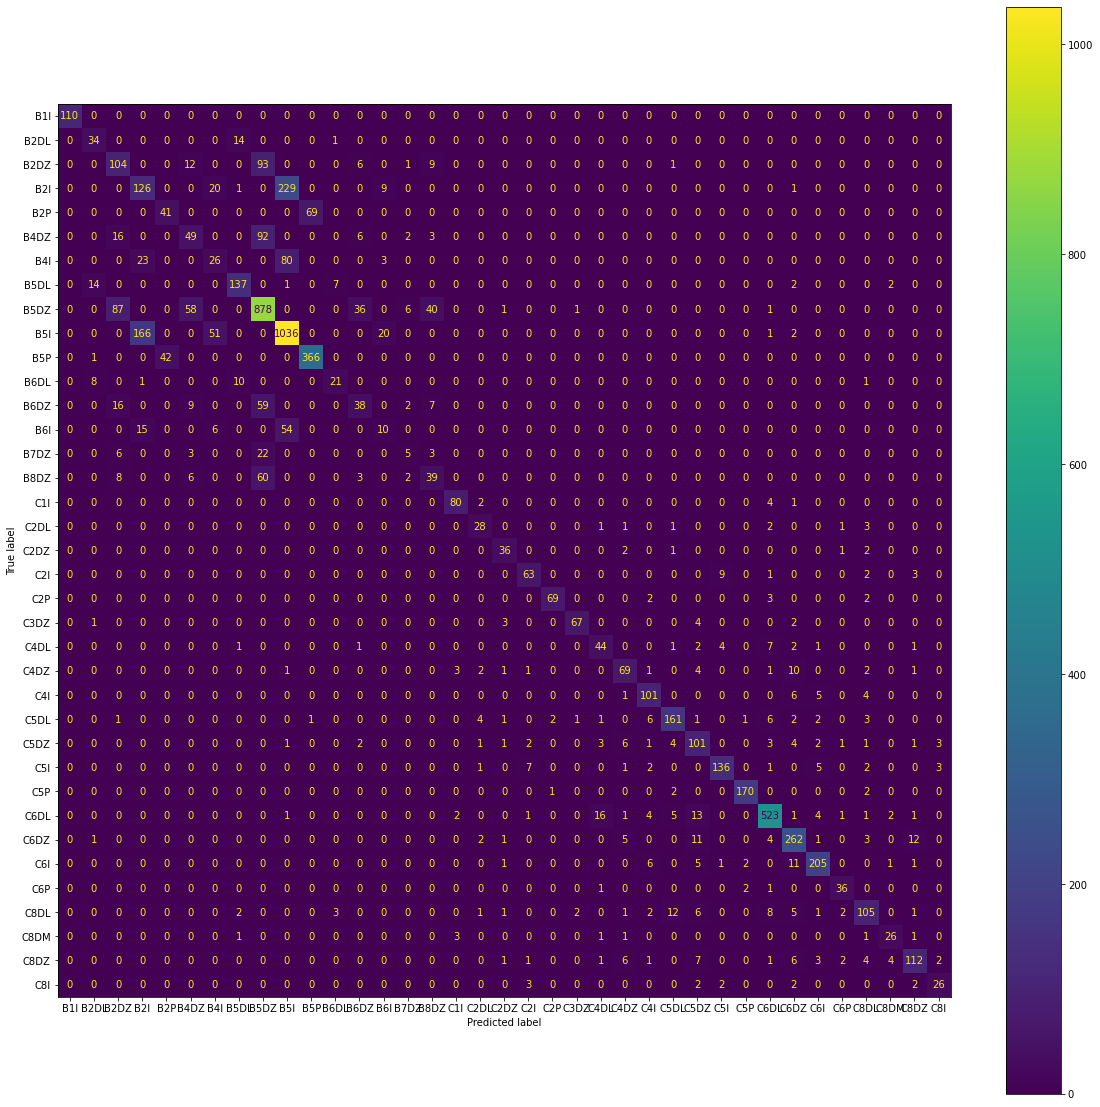

In [12]:
# Create an Confusion Matrix to get an insight of how well the model is performing. 
fig, ax = plt.subplots(figsize=(20,20))
plot_confusion_matrix(clf_dt, X_test, y_test, ax=ax)
fig.savefig('confusion_matrix_DT.png')

In order to visulation the gridsearch, we needed to make an figure. This can be seen in Figure X in the thesis. 

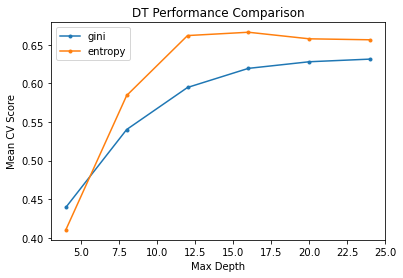

In [13]:
results_DT = pd.DataFrame(grid.cv_results_['params'])
results_DT['test_score'] = grid.cv_results_['mean_test_score']
for i in ['gini', 'entropy']:
    temp = results_DT[results_DT['criterion'] == i]
    temp_average = temp.groupby('max_depth').agg({'test_score': 'mean'})
    plt.plot(temp_average, marker = '.', label = i)
    
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("DT Performance Comparison")
plt.savefig('DT Performance Comparison.png')
plt.show()

Om de onderzoeks vraag: Are there neighborhood socio-demographic characteristics which are predictive of the use of youth caresegments? is onderstaande code nodig

In [14]:
# Get numerical feature importances
importances = list(clf_dt.feature_importances_)
feature_list = list(X_encoded.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Bedrag Goedgekeurd   Importance: 0.78
Variable: Leeftijd             Importance: 0.06
Variable: Geslacht_0           Importance: 0.01
Variable: Postcode             Importance: 0.0
Variable: BEVTOTAAL            Importance: 0.0
Variable: BEVMAN               Importance: 0.0
Variable: BEVVROUW             Importance: 0.0
Variable: BEVMAN_P             Importance: 0.0
Variable: BEVVROUW_P           Importance: 0.0
Variable: BEVBRIEF             Importance: 0.0
Variable: BEVINST              Importance: 0.0
Variable: BEVINST_P            Importance: 0.0
Variable: BEVPOTBBV15_64       Importance: 0.0
Variable: BEVPOTBBV15_64_P     Importance: 0.0
Variable: BEVPOTBBV15_65       Importance: 0.0
Variable: BEVPOTBBV15_74       Importance: 0.0
Variable: BEVPOTBBV15_74_P     Importance: 0.0
Variable: BEVSUR               Importance: 0.0
Variable: BEVANTIL             Importance: 0.0
Variable: BEVTURK              Importance: 0.0
Variable: BEVMAROK             Importance: 0.0
Variable: 

In order to make a plot, which is more nice to have in our report, the code below is needed 

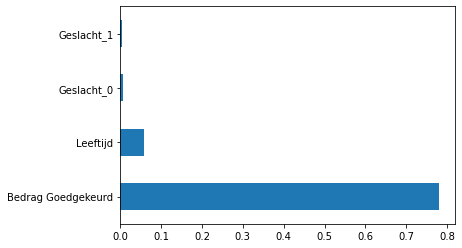

In [15]:
feat_importances = pd.Series(clf_dt.feature_importances_, index=X_train.columns)
fig = plt.figure()
fig.add_subplot(feat_importances.nlargest(4).plot(kind='barh'))
fig.savefig('feature Importance.png')

See part "Results"
After seeing the results, we can see that "bedrag goedgekeurd" has a very high level of importance. Beceasue this variable is generated by our self, we wanted to investigate more in order to see what the overall performance is on the whole model.
For doing this, we needed to re-load the data, an make an new model with this data.

In [16]:
df = pd.read_pickle("C:\\VERTROUWELIJK\\final_dataSet.pkl")
X_bedrag = df.drop(['Voorziening','Bedrag Goedgekeurd'], axis=1)

X_encoded_bedrag = pd.get_dummies(X_bedrag, columns=['Geslacht'])
# X_encoded_bedrag
X_train, X_test, y_train, y_test = train_test_split(X_encoded_bedrag,y,random_state=42)


In [17]:
clf_dt = DecisionTreeClassifier()
clf_dt = clf_dt.fit(X_train, y_train)
calculateMetrics(clf_dt)

DecisionTreeClassifier()
F1 score
0.19047619047619047


Get the Standard deviadtion of the Bedrag Goedgekeurd grouped by the Voorzieningen. In combinaten with the mean, we can check if one voorziening is straitforward for one "bedrag goedgekeurd" 

In [18]:
df.groupby('Voorziening')['Bedrag Goedgekeurd'].std()

Voorziening
B1I       317.226729
B2DL      816.739660
B2DZ     2087.462985
B2I       715.182106
B2P       371.144779
B4DZ     2090.864953
B4I       692.741636
B5DL      833.549773
B5DZ     2017.840459
B5I       751.831953
B5P       357.051589
B6DL      832.422321
B6DZ     2152.504200
B6I       575.654187
B7DZ     2050.682442
B8DZ     2055.769005
C1I      3131.879969
C2DL     4279.050353
C2DZ    10183.944798
C2I     13351.120452
C2P      4573.036893
C3DZ     9278.837079
C4DL     9082.417640
C4DZ    26179.119215
C4I     11786.443170
C5DL     5104.716533
C5DZ    23265.366922
C5I     12855.862339
C5P      3554.448887
C6DL     5602.342009
C6DZ    37674.846784
C6I     12956.147004
C6P      7722.993663
C8DL    13200.701380
C8DM    12402.558698
C8DZ    27117.952224
C8I     18935.750653
Name: Bedrag Goedgekeurd, dtype: float64

In [19]:
df.groupby('Voorziening')['Bedrag Goedgekeurd'].mean()

Voorziening
B1I       761.192893
B2DL     1376.797788
B2DZ     3823.370066
B2I      2348.698264
B2P      1138.636364
B4DZ     3921.966927
B4I      2308.186620
B5DL     1451.977027
B5DZ     3674.094590
B5I      2484.005857
B5P      1199.970203
B6DL     2001.494667
B6DZ     3611.163262
B6I      2470.000000
B7DZ     4342.518193
B8DZ     4438.219298
C1I      7566.890411
C2DL     9375.273299
C2DZ    19800.232558
C2I     22535.490196
C2P      9476.589744
C3DZ    18884.445312
C4DL    16373.138786
C4DZ    33702.238095
C4I     19376.135516
C5DL     8332.396739
C5DZ    23553.266762
C5I     25267.747041
C5P      9309.605672
C6DL    13981.283178
C6DZ    44979.923481
C6I     23125.938304
C6P     11425.098214
C8DL    15653.104694
C8DM    24562.558824
C8DZ    42699.052560
C8I     37134.180556
Name: Bedrag Goedgekeurd, dtype: float64

For visulating the four highest freq of voorzieningen, we need the following code.

In [20]:
df['Voorziening'].value_counts().nlargest(4)

B5I     5122
B5DZ    4322
C6DL    2272
B5P     1678
Name: Voorziening, dtype: int64

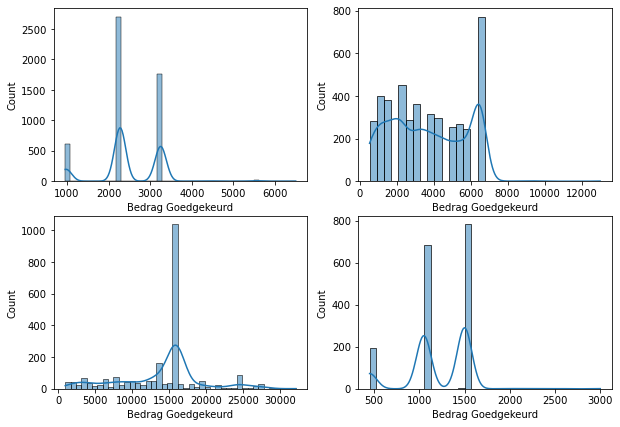

In [21]:
fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(10)

ax = fig.add_subplot(2, 2, 1)
sns.histplot(df[df['Voorziening'] == 'B5I']['Bedrag Goedgekeurd'], ax=ax, kde=True)
ax = fig.add_subplot(2, 2, 2)
sns.histplot(df[df['Voorziening'] == 'B5DZ']['Bedrag Goedgekeurd'],ax=ax, kde=True)
ax = fig.add_subplot(2, 2, 3)
sns.histplot(df[df['Voorziening'] == 'C6DL']['Bedrag Goedgekeurd'],ax=ax,kde=True)
ax = fig.add_subplot(2, 2, 4)
sns.histplot(df[df['Voorziening'] == 'B5P']['Bedrag Goedgekeurd'],ax=ax,kde=True)
fig.savefig('overview for voorzieningen distplot.png')

To see the "new" feature importance, we created this new fig. 

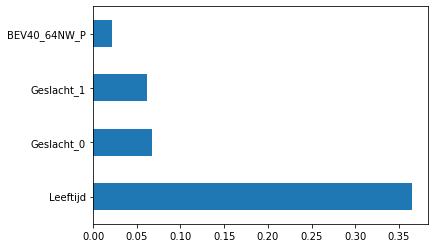

In [22]:
feat_importances = pd.Series(clf_dt.feature_importances_, index=X_train.columns)
fig = plt.figure()
fig.add_subplot(feat_importances.nlargest(4).plot(kind='barh'))
fig.savefig('feature Importance removed Bedrag.png')